This notebook presents the semi-physical model of the L1 laser in its second version, based on PyTorch.

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague


# Motivation

The goal of this project is to maximise second-harmonic efficiency. However, since it is also very much related to the shortest possible pulse shape, we started with developing a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which, by default, is the shortest one typically). 

However, since data are really expensive to empirically collect we resorted to model the underlying dynamics of the whole system, also considering that (even if not exhaustive) there is a significant amount of know-how concerned with the considered dynamics available.
This knowledge about the actual physical process is presented in the following Figure. 

![](images/semi-physical_model.png)

The very same diagram can also be represented by means of a **computational graph**, presented in the following Figure:

![](images/semiphysicalmodel-computational_graph.png)

This visualisation shows how the sequence of operations that do lead to the final temporal shape is the **succession of much more elementary operations**. 

This is particularly useful when auto-differentiation can be deployed. In this particular setting because, if one represents the semiphysical model as a computational graph, then it is possible to access, very cheaply in terms of computational time and effort (and with high analytical precision), to those **differential information** which are crucial to **apply methods such as Newton Method or any gradient-based method**.

Surely enough, such a model is practically applicable only under the assumption that $y_3(\nu)$ is a *good approximation* of $y_{REAL, 3}(\nu)$. 

Luckily enough, various are the frameworks supporting auto-differentiation. One of this is **Pytorch**. Using it basically requires to rewrite the majority of the code present in the initial version of the semi-physical model, considering the data abstraction of this framework, i.e. **tensors** instead of **arrays**. 

In [1]:
# imports and data acquisition
import numpy as np
import torch
from typing import Tuple
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../")

import os
import pandas as pd
from scipy.constants import c

from utils.LaserModel import LaserModel
data_path = "../data/L1_pump_spectrum.csv"

# read the data
df = pd.read_csv(data_path, header = None)
df.columns = ["Wavelength (nm)", "Intensity"]
# converting Wavelength in Frequency
df["Frequency (THz)"] = df["Wavelength (nm)"].apply(lambda wavelenght: 1e-12 * (c/(wavelenght * 1e-9)))
# clipping everything that is negative
df["Intensity"] = df["Intensity"].apply(lambda intensity: np.clip(intensity, a_min = 0, a_max = None))
# the observations must be returned for increasing values of frequency
df = df.sort_values(by = "Frequency (THz)")

frequency, intensity = df.loc[:, "Frequency (THz)"].values, df.loc[:, "Intensity"].values
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())
field = np.sqrt(intensity)

Once the data are ingested it is possible to elaborate them as usual (i.e., using already defined methods) since no differential information about this step is necessary.

In [2]:
# preprocessing steps
from utils.physics import *
# preprocessing
cutoff = np.array((289.95, 291.91)) * 1e12
# cutting off the signal
frequency_clean, field_clean = cutoff_signal(frequency_cutoff = cutoff, frequency = frequency * 1e12,
                                             signal = field)
# augmenting the signal
frequency_clean_aug, field_clean_aug = equidistant_points(frequency = frequency_clean,
                                                          signal = field_clean,
                                                          num_points = int(3e3)) # n_points defaults to 5e3
# retrieving central carrier
central_carrier = central_frequency(frequency = frequency_clean_aug, signal = field_clean_aug)

In [3]:
intensity = torch.from_numpy(field ** 2)
frequency, field = torch.from_numpy(frequency_clean_aug), torch.from_numpy(field_clean_aug)

The following functions take care of modelling the first block of the computational graph, the one that takes as input the control quantities (whose gradient must be used) and outputs the physical entity that is necessary to use, i.e. $\varphi_S$. 


![](images/computationalgraph_block1.png)

In [4]:
def translate_control(central_frequency:float, control:torch.tensor, verse:str = "to_gdd")->torch.tensor: 
        """This function translates the control quantities either from Dispersion coefficients (the di's) to GDD, TOD and FOD using a system of linear equations 
        defined for this very scope or the other way around, according to the string "verse".  

        Args:
            central_frequency (float): Central frequency of the spectrum, expressed in Hz.
            control (torch.tensor): Control quanitities (either the di's or delay information). Must be given in SI units.
            verse (str, optional): "to_gdd" to translate control from dispersion coefficients to (GDD, TOD and FOD), solving Ax = b.
            "to_disp" to translate (GDD, TOD and FOD) to dispersion coefficient left-multiplying the control by A. Defaults to "to_gdd". 

        Returns:
            torch.tensor: The control translated according to the verse considered.
        """
         # central wavelength (using c/f = lambda)
        central_wavelength = c / central_frequency

        a11 = (-2 * torch.pi * c)/(central_wavelength ** 2) #; a12 = a13 = 0
        a21 = (4 * torch.pi * c)/(central_wavelength ** 3); a22 = ((2 * torch.pi * c)/(central_wavelength ** 2))**2 # a23 = 0
        a31 = (-12 * torch.pi * c)/(central_wavelength ** 4); a32 = -(24 * (torch.pi * c) ** 2)/(central_wavelength ** 5); a33 = -((2 * torch.pi * c) / (central_wavelength ** 2)) ** 3

        A = torch.tensor([
            [a11, 0, 0], 
            [a21, a22, 0], 
            [a31, a32, a33]
        ], dtype = torch.float64
        )

        if verse.lower() == "to_gdd": 
            d2, d3, d4 = control
            # solving the conversion system using forward substitution
            GDD = d2 / a11; TOD = (d3 - a21 * GDD)/(a22); FOD = (d4 - a31 * GDD - a32 * TOD)/(a33)
            # grouping the tensors maintaing information on the gradient
            return torch.stack([GDD, TOD, FOD])

        elif verse.lower() == "to_disp": 
            return A @ control
        else: 
            raise ValueError('Control translatin is either "to_gdd" or "to_disp"!')

def phase_equation(frequency:torch.tensor, central_frequency:float, control:torch.tensor) -> torch.tensor: 
    """This function returns the phase with respect to the frequency and some control parameters.

    Args:
        frequency (torch.tensor): Tensor of frequencies considered (measured in Hz)
        central_frequency (float): Central frequency, not angular (measured in Hz).
        control (torch.tensor): Control parameters to be used to create the phase. It contains GDD, TOD and FOD in s^2, s^3 and s^4.

    Returns:
        torch.tensor: The phase with respect to the frequency, measured in radiants.
    """
    GDD, TOD, FOD = control
    phase = \
            (1/2)* GDD * (2*torch.pi * (frequency - central_frequency))**2 + \
            (1/6)* TOD * (2*torch.pi * (frequency - central_frequency))**3 + \
            (1/24)* FOD * (2*torch.pi * (frequency - central_frequency))**4
    return phase

Considering now the complete fictional control vector $\psi = (d_2, d_3, d_4)$ these functions can be tested on whether or not they can store gradient informations.

In [5]:
psi = torch.rand(size = (3,), requires_grad = True, dtype = torch.double)
translated_control = translate_control(central_frequency = central_carrier, control = psi, verse = "to_gdd")
print("Control translator gradient: ", translated_control.grad_fn)

obtained_phase = phase_equation(frequency = frequency,
                                central_frequency = central_carrier,
                                control = translated_control)
print("Phase function gradient: ", obtained_phase.grad_fn)

Control translator gradient:  <StackBackward0 object at 0x7fdd5c7c7490>
Phase function gradient:  <AddBackward0 object at 0x7fdd5c7c7490>


Once is it clear that this first block does propagate differential information it is important to model the second block of the computational graph, which is implementing a key operation for the whole process. 


![](images/computationalgraph_block2.png)

In [6]:
def impose_phase(spectrum:torch.tensor, phase:torch.tensor)->torch.tensor: 
    """This function imposes a phase on a particular signal.
    
    Args: 
        spectrum (torch.tensor): Tensor representing the signal considered.
        phase (torch.tensor): The phase to impose on the signal.
    
    Returns: 
        torch.tensor: New spectrum with modified phase
    """
    return spectrum * torch.exp(1j * phase)

In [7]:
# testing
y1 = impose_phase(field, obtained_phase)
print("Phase imposition gradient: ", y1.grad_fn)

Phase imposition gradient:  <MulBackward0 object at 0x7fdd5c7c6200>


This very block will be used many other times in the whole computation of the final shape, hence its usefulness. 

Furthermore, it is possible to reproduce the block which models the YB:Yab. 

In [8]:
def yb_gain(signal:torch.tensor, intensity_yb:torch.tensor, n_passes:int=50)->torch.tensor: 
    """This function models the passage of the signal in the cristal in which yb:yab gain is observed.
    
    Args: 
        signal (torch.tensor): The intensity signal that enters the system considered.
        intensity_yb (torch.tensor): The gain intensity of the crystal
        n_passes (int, optional): The number of times the beam passes through the crystal where spectrum narrowing is observed. 
        
    Returns: 
        torch.tensor: New spectrum, narrower because of the gain. 
    """
    return signal * (intensity_yb ** n_passes)

In [9]:
# testing
y1_tilde = yb_gain(y1, torch.rand(size = y1.shape))
print("Spectrum narrowing function gradient: ", y1_tilde.grad_fn)

Spectrum narrowing function gradient:  <MulBackward0 object at 0x7fdd5c7c62f0>


The final black whose modelling is necessary is the block that converts a signal with a given phase to its temporal profile information. This block is represented in the following Figure. 


![](images/computationalgraph_block3.png)

In [10]:
def temporal_profile(frequency:torch.tensor, field:torch.tensor, npoints_pad:int=int(1e4), return_time:bool=True) -> Tuple[np.array, np.array]:
    """This function returns the temporal profile of a given signal represented in the frequency domain. Padding is added so as to have more points and increase FFT algorithm output's quality. 

    Args:
        frequency (torch.tensor): Array of frequencies considered (measured in Hz)
        field (torch.tensor): Array of field measured in the frequency domain. 
        npoints_pad (int, optional): Number of points to be used in padding. Padding will be applied using half of this value on the
        right and half on the left. Defaults to int(1e4).
        return_time (bool, optional): Whether or not to return also the time frame of the signal to be used on the x-axis. Defaults to True. 
    Returns:
        Tuple[np.array, np.array]: Returns either (time, intensity) (with time measured in in seconds) or intensity only.
    """
    step = torch.diff(frequency)[0]
    # centering the array in its peak
    time = torch.fft.fftshift(torch.fft.fftfreq(len(frequency) + npoints_pad, d=abs(step)))
    # centering the signal in its peak
    intensity_frequency = field * torch.conj(field) # only for casting reasons
    # going from frequency to time
    intensity_time = torch.real(torch.fft.ifft(intensity_frequency))
    # normalizing the resulting signal
    intensity_time / intensity_time.max() # normalizing
    
    # either returning time or not according to return_time
    if not return_time: 
        return intensity_time
    else: 
        return time, intensity_time

In [11]:
# testing
time, pulse_temporal = temporal_profile(frequency, y1_tilde)
print("Temporal profile function gradient: ", pulse_temporal.grad_fn)

Temporal profile function gradient:  <SelectBackward0 object at 0x7fdd57c37310>


Once all of the different blocks have been defined it is possible to group them in one single object representative of the whole process. This object is also presented in `utils/LaserModel_torch.py`. 

In [12]:
compressor_params = torch.tensor([267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50], dtype = torch.double)
from utils.LaserModel_torch import ComputationalLaser as CL
laser = CL(frequency = frequency * 1e-12, field = field, compressor_params = compressor_params)
try_control = -1 * compressor_params
try_control.requires_grad_(requires_grad = True)

time, profile = laser.forward_pass(try_control)
timeTL, profileTL = laser.transform_limited()

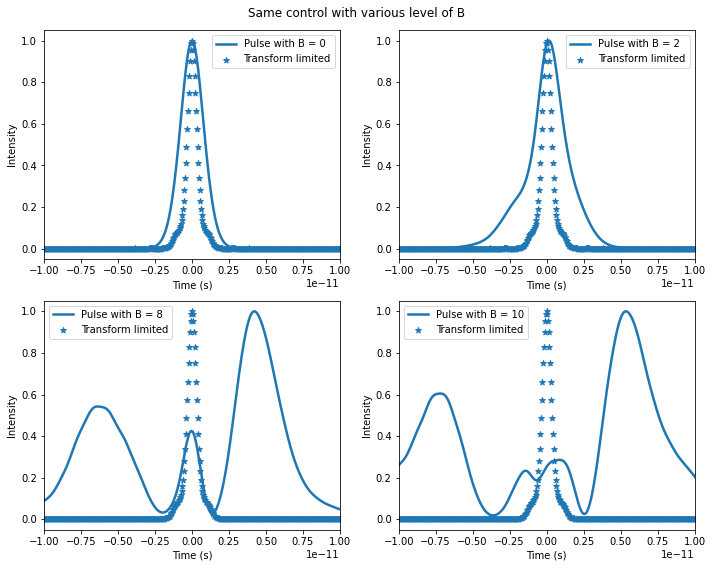

In [13]:
fig, ax = plt.subplots(figsize = (10,8), nrows = 2, ncols = 2)
fig.suptitle("Same control with various level of B")
idx = 0
for B in [0, 2, 8, 10]: 
    current = ax[idx//2, idx%2]
    laser.B = B
    time, profile = laser.forward_pass(try_control)
    
    current.plot(timeTL.detach(), profile.detach(), label = f"Pulse with B = {B}", lw = 2.5)
    current.scatter(timeTL.detach(), profileTL.detach(), marker = "*", label = "Transform limited")
    
    current.set_xlabel("Time (s)"); current.set_ylabel("Intensity")
    current.set_xlim(-1e-11, 1e-11)
    current.legend()
    idx += 1
fig.tight_layout()

Once a model returning temporal profiles is available it can be used for optimisation as long as it fast running enough. 

In [15]:
import time
start_time = time.time()
laser.forward_pass(try_control)
print("Forward pass in {:.4e}".format(time.time() - start_time))

Forward pass in 9.9173e-03


This is model is fast enough, even on commercial hardware, to be scaled when needed. Plus, it does have really the really good property of actually supporting gradients, which implies that it could be used in the context of optimization. 